In [31]:
import numpy as np
import pandas as pd
from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')


train = pd.read_csv('C:\\Users\\smaxt\\Desktop\\deeplearning\\boston_housing_prices\\train.csv', index_col='Id')
test = pd.read_csv('C:\\Users\\smaxt\\Desktop\\deeplearning\\boston_housing_prices\\test.csv', index_col='Id')
submission = pd.read_csv('C:\\Users\\smaxt\\Desktop\\deeplearning\\boston_housing_prices\\sample_submission.csv', index_col='Id')

data = train
print(train.shape, test.shape, submission.shape)
#1460행의 train 데이터
#1460 test 데이터의 집값을 예측해야함, 변수는 79개

(1460, 80) (1459, 79) (1459, 1)


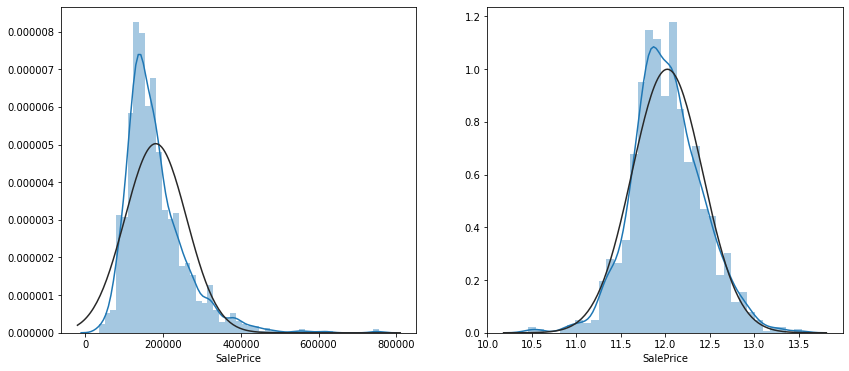

In [32]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(data['SalePrice'],fit=norm, ax=ax1)
sns.distplot(np.log(data['SalePrice']+1),fit=norm, ax=ax2)
#distplot 기능 알아보기,
#로그취할때 +1을 왜 해주는거지?

#좌측은, 타겟 변수의 분포 우측은, 타겟 변수에 로그를 취한 분포
#좌측이 왜도가 심하다는 것을 확인할 수 있어서, 로그를 취해 정규분포 모양에 가깝게 바꿔준다.

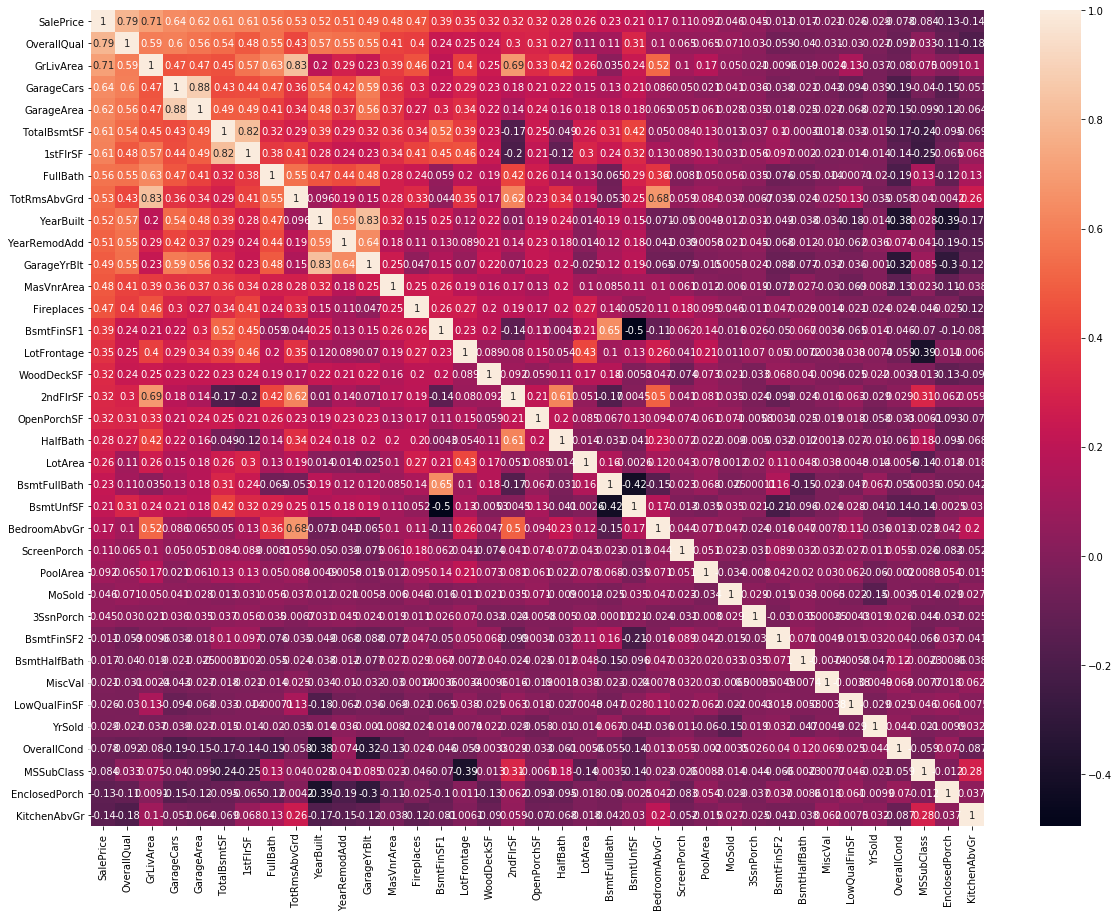

In [33]:
corr = data.corr()
#data의 상관계수를 따온다
top_corr = data[corr.nlargest(40,'SalePrice')['SalePrice'].index].corr()
#이 문장은 잘 모르겠다.
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot= True, ax=ax1)
#타겟변수인 SalePrice와 가장 큰 상관관계를 가진 40개의 변수를 표시

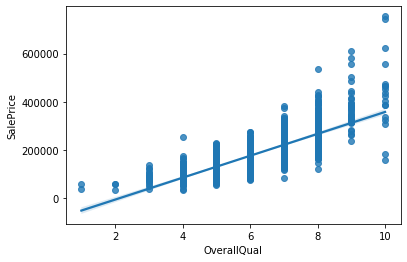

In [34]:
sns.regplot(data['OverallQual'],data['SalePrice'])
#첫 번째로 가장 
#이건 왜 그래프가 이렇게 나오는걸까?

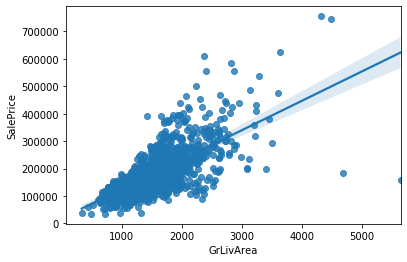

In [35]:
sns.regplot(data['GrLivArea'],data['SalePrice']) 
#오른쪽 끝부분 GrLiv의 두 값이 거슬린다.

In [36]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
#그래서 끝에 둘 잘라내었다.

In [37]:
Ytrain = train['SalePrice']
train = train[list(test)]
all_data=pd.concat((train,test), axis=0)
print(all_data.shape)
Ytrain = np.log(Ytrain+1)

(2917, 79)


In [38]:
##### 전체 데이터에서 결측치 확인 ######
#집에 시설물이 없는 경우, 결측치로 처리가 되어있다.
cols=list(all_data)
for col in list(all_data):
    if(all_data[col].isnull().sum()) == 0:
        cols.remove(col)
    else:
        pass
print(len(cols))

34


In [39]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')
#집에 해당 시설물이 없는 경우(범주형 변수)
#결측치를 None이라는 문자열로 채우겠다. (None과 'None'은 다르다!)

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)
#수치형변수
#결측치를 0으로 채우겠다 ex/ 차고면적 = 0  == 차고 없음
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
#
print(f"Total count of missing values in all_data : {all_data.isnull().sum().sum()}")

Total count of missing values in all_data : 0


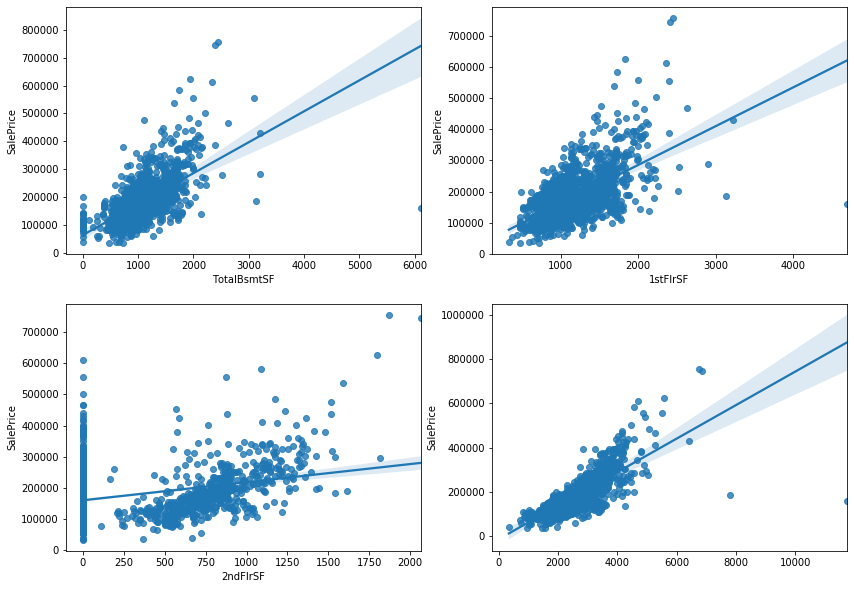

In [40]:
#본격적인 데이터 분석 (EDA : Exploratory Data Analysis 탐색적 데이터 분석) 
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.regplot(data['TotalBsmtSF'], data['SalePrice'], ax=ax1)
sns.regplot(data['1stFlrSF'], data['SalePrice'],ax=ax2)
sns.regplot(data['2ndFlrSF'], data['SalePrice'],ax=ax3)
sns.regplot(data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'],data['SalePrice'],ax=ax4)
#우측 아래 그래프가 '총 면적' 그래프다.
#보기만 해도 나머지보다, 대변을 잘 해준다는 것을 알 수 있다.
#총 면적이 증가하면 집값이 높아진다
#(근데 이건 너무 당연한거 아닌가...?)

In [41]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['No2ndFlr'] = (all_data['2ndFlrSF']==0) #위와 반대로 2층없음
all_data['NoBsmt'] = (all_data['TotalBsmtSF']==0) # 지하실 없음을 표현하자.

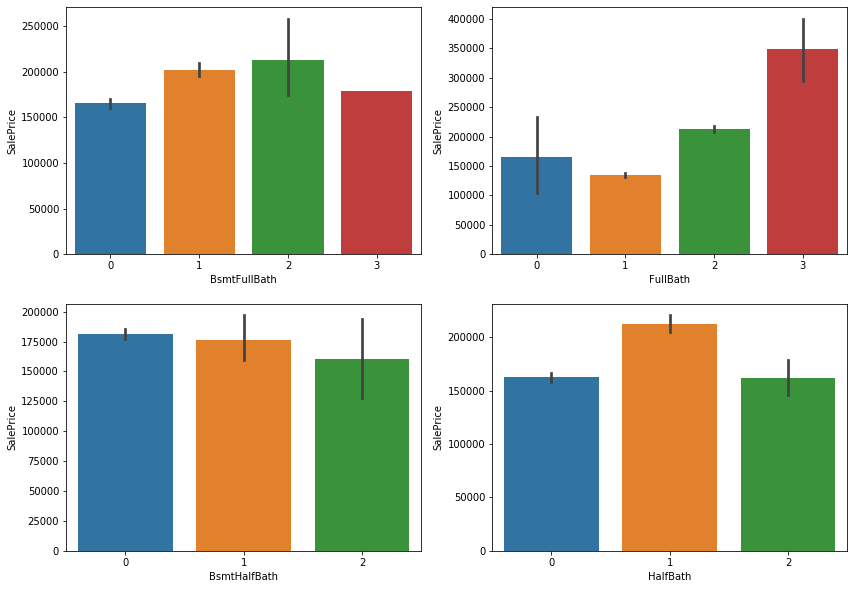

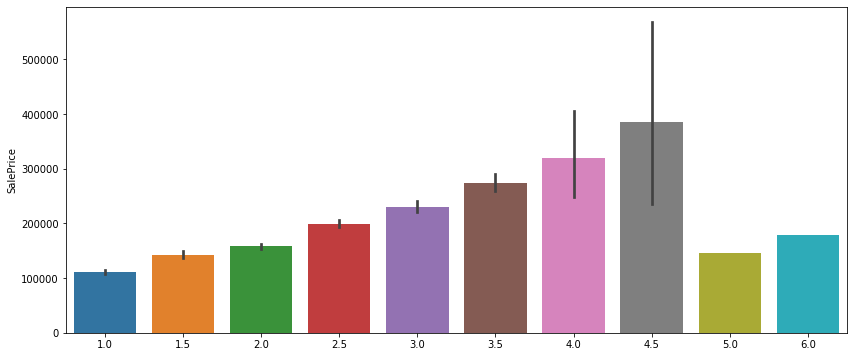

In [42]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.barplot(data['BsmtFullBath'], data['SalePrice'], ax = ax1)
sns.barplot(data['FullBath'], data['SalePrice'], ax = ax2)
sns.barplot(data['BsmtHalfBath'], data['SalePrice'], ax = ax3)
sns.barplot(data['HalfBath'], data['SalePrice'], ax = ax4)

figure, (ax5) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(14,6)
sns.barplot(data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + 
           (data['HalfBath']/2), data['SalePrice'], ax= ax5)
#더 큰 집일수록 욕실수가 많지 않겠는가?

#맨 아래 그래프를 참조했을때, 점증이 아니라 욕실 합계가 5개 6개에서 SalePrice가 하락하는 기현상을 볼 수 있다.
#그리고 5.0,6.0에는 없는 검은 세로선은 "편차"를 의미한다.
#편차가 없는 5.0, 6.0을 수치가 몇 개 없는 outlier를 의미한다. 따라서 5,6개는 신경쓰지 않아도 좋다.

In [43]:
all_data['TotalBath']= all_data['BsmtFullBath']+all_data['FullBath']+(all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

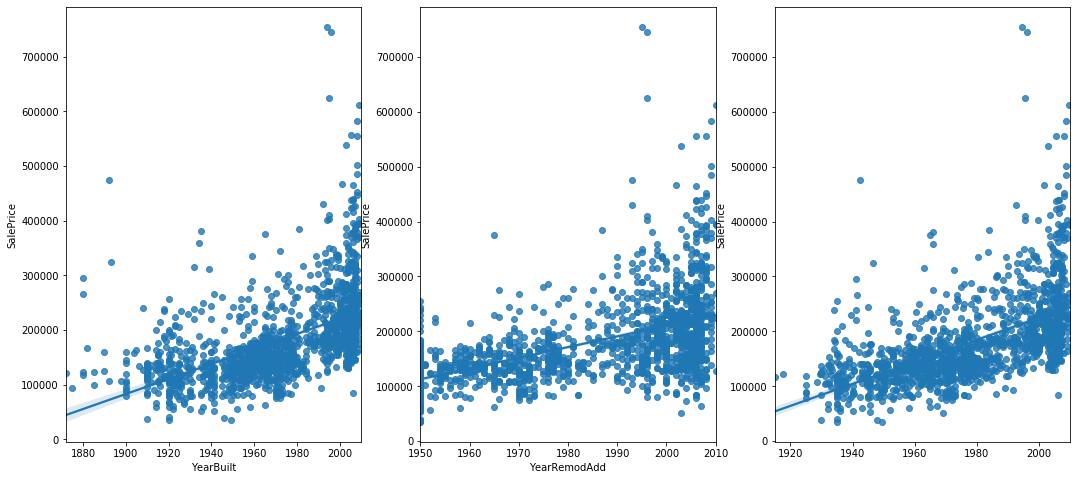

In [44]:
#건축 연도 + 리모델링 연도
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)
sns.regplot(data['YearBuilt'],data['SalePrice'],ax=ax1)
sns.regplot(data['YearRemodAdd'],data['SalePrice'],ax=ax2)
sns.regplot((data['YearBuilt']+data['YearRemodAdd'])/2,data['SalePrice'], ax=ax3)
#/2 for graph scaling
#건축연도와 리모델링연도의 평균을 구하는 것
#건축연도가 오래되었어도 최근에 리모델링 했다면 값이 높을 것이란 추측
#반대로, 건축연도는 오래되었지만 리모델링X == 맨 오른쪽 값이 낮을 것이다.



In [45]:
all_data['YrBltAndRemod'] = all_data['YearBuilt']+all_data['YearRemodAdd']

In [46]:
#자료형 수정
all_data['MSSubClass']=all_data['MSSubClass'].astype(str)
all_data['MoSold']=all_data['MoSold'].astype(str)
all_data['YrSold']=all_data['YrSold'].astype(str)
#MSSubClass는 숫자로 이뤄진 데이터지만,
#각각의 숫자가 의미를 갖고있는 범주형 변수다.
#따라서 연,월,연도 역시 연산 개념을 적용하는데는 무리가 있다.

In [47]:
#지하실 점수
Basement = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
Bsmt=all_data[Basement]

In [48]:
#지하실 점수 인코딩
Bsmt=Bsmt.replace(to_replace='Po', value=1)
Bsmt=Bsmt.replace(to_replace='Fa', value=2)
Bsmt=Bsmt.replace(to_replace='TA', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)
Bsmt=Bsmt.replace(to_replace='Ex', value=5)
Bsmt=Bsmt.replace(to_replace='None', value=0)

Bsmt=Bsmt.replace(to_replace='No', value=1)
Bsmt=Bsmt.replace(to_replace='Mn', value=2)
Bsmt=Bsmt.replace(to_replace='Av', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)

Bsmt=Bsmt.replace(to_replace='Unf', value=1)
Bsmt=Bsmt.replace(to_replace='LwQ', value=2)
Bsmt=Bsmt.replace(to_replace='Rec', value=3)
Bsmt=Bsmt.replace(to_replace='BLQ', value=4)
Bsmt=Bsmt.replace(to_replace='ALQ', value=5)
Bsmt=Bsmt.replace(to_replace='GLQ', value=6)

In [49]:
#지하실의 전반적인 상태를 종합한 점수
Bsmt['BsmtScore'] = Bsmt['BsmtQual'] * Bsmt['BsmtCond'] * Bsmt['TotalBsmtSF']
all_data['BsmtScore'] = Bsmt['BsmtScore']

#지하실이 공사중이라면,완성 & 면적과 상태를 포함
Bsmt['BsmtFin'] = (Bsmt['BsmtFinSF1'] * Bsmt['BsmtFinType1']) + (Bsmt['BsmtFinSF2'] * Bsmt['BsmtFinType2'])
all_data['BsmtFinScore']=Bsmt['BsmtFin']
all_data['BsmtDNF'] = (all_data['BsmtFinScore']==0)

In [50]:
#토지 점수 (lot)
lot = ['LotFrontage', 'LotArea','LotConfig','LotShape']
Lot=all_data[lot]

Lot['LotScore'] = np.log((Lot['LotFrontage'] * Lot['LotArea'])+1)
all_data['LotScore'] = Lot['LotScore']

In [51]:
#차고 점수(garage)
garage = ['GarageArea', 'GarageCars', 'GarageCond','GarageFinish', 'GarageQual','GarageType','GarageYrBlt']
Garage = all_data[garage]
all_data['NoGarage']=(all_data['GarageArea']==0)

In [52]:
Garage=Garage.replace(to_replace='Po', value=1)
Garage=Garage.replace(to_replace='Fa', value=2)
Garage=Garage.replace(to_replace='TA', value=3)
Garage=Garage.replace(to_replace='Gd', value=4)
Garage=Garage.replace(to_replace='Ex', value=5)
Garage=Garage.replace(to_replace='None', value=0)

Garage=Garage.replace(to_replace='Unf', value=1)
Garage=Garage.replace(to_replace='RFn', value=2)
Garage=Garage.replace(to_replace='Fin', value=3)

Garage=Garage.replace(to_replace='CarPort', value=1)
Garage=Garage.replace(to_replace='Basment', value=4)
Garage=Garage.replace(to_replace='Detchd', value=2)
Garage=Garage.replace(to_replace='2Types', value=3)
Garage=Garage.replace(to_replace='Basement', value=5)
Garage=Garage.replace(to_replace='Attchd', value=6)
Garage=Garage.replace(to_replace='BuiltIn', value=7)
Garage['GarageScore']=(Garage['GarageArea']) * (Garage['GarageCars']) * (Garage['GarageFinish']) * (Garage['GarageQual']) * (Garage['GarageType'])
all_data['GarageScore']=Garage['GarageScore']

In [53]:
#기타 변수
#1) 비정상적으로 하나의 값만 많은 변수 삭제
#all_data=all_data.drop(columns=['Street','Utilities','Condition2','RoofMatl','Heating'])
#흠...이건 왜 안될까?

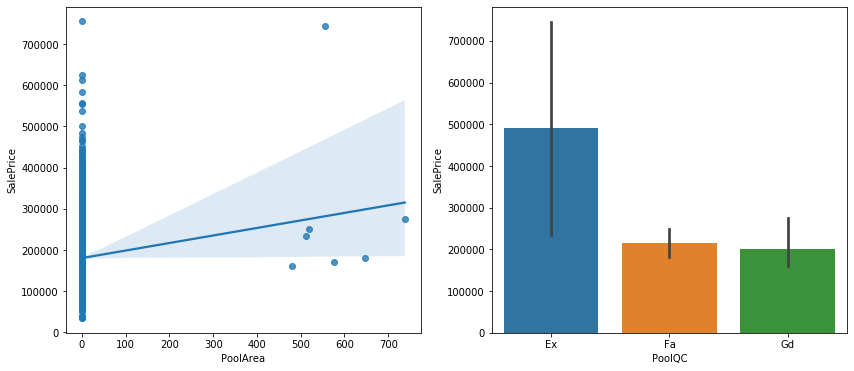

In [54]:
#빈 값이 많은 변수 삭제
#수영장이 있는 집
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='PoolArea', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='PoolQC', y='SalePrice',ax=ax2)

In [55]:
all_data = all_data.drop(columns=['PoolArea','PoolQC'])

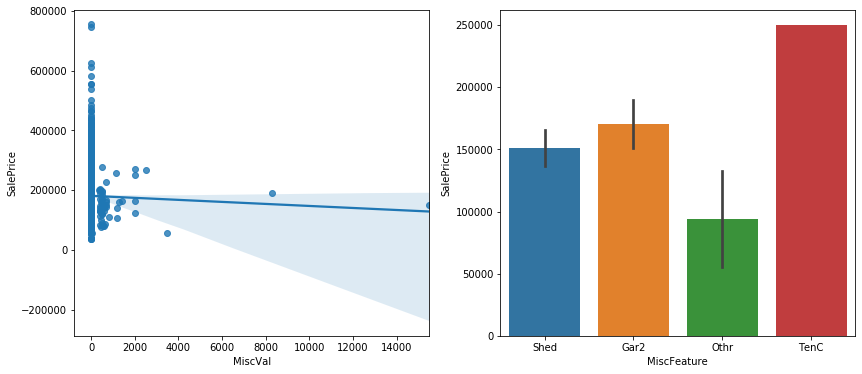

In [56]:
#테니스 코트가 있는 집
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='MiscVal', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='MiscFeature', y='SalePrice', ax=ax2)


In [57]:
all_data = all_data.drop(columns=['MiscVal','MiscFeature'])

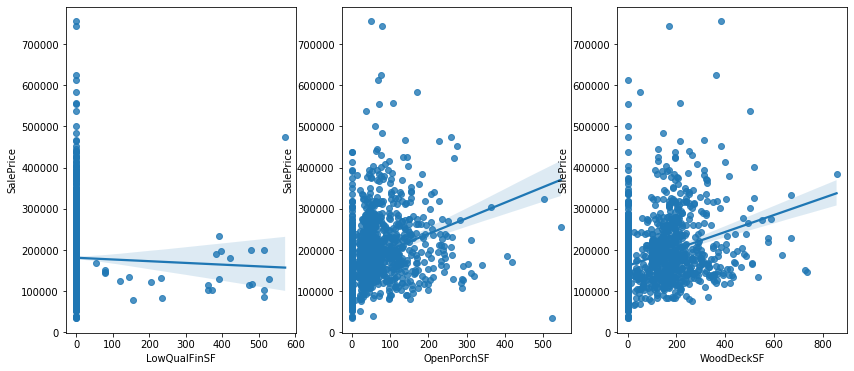

In [58]:
#(채워진) 결측치가 많은 경우
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(14,6)

sns.regplot(data=data, x='LowQualFinSF', y='SalePrice',ax=ax1)
sns.regplot(data=data, x='OpenPorchSF', y='SalePrice',ax=ax2)
sns.regplot(data=data, x='WoodDeckSF', y='SalePrice',ax=ax3)

In [59]:
all_data['NoLowQual']=(all_data['LowQualFinSF']==0)
all_data['NoOpenPorch']=(all_data['OpenPorchSF']==0)
all_data['NoWoodDeck']=(all_data['WoodDeckSF']==0)
#0값만 불리해주면 결과가 괜찮을 것 같대서 0만 분리했다는데
#뭔소리지?

In [62]:
#전처리 (Preprocessing)
#범주형 변수가 상당히 많은 데이터, 범주형 변수를 1,2,3,4로 해버리면
# 머신러닝이 오해할 소지가 생기므로 One-hot 인코딩을 한다.
non_numeric=all_data.select_dtypes(np.object)

def onehot(col_list):
    global all_data
    while len(col_list) !=0:
        col=col_list.pop(0)
        data_encoded=pd.get_dummies(all_data[col], prefix=col)
        all_data=pd.merge(all_data, data_encoded, on='Id')
        all_data=all_data.drop(columns=col)
    print(all_data.shape)
    
onehot(list(non_numeric))

(2917, 334)


In [63]:
#수치형 변수
numeric = all_data.select_dtypes(np.number)

#왜도만 조정해준다.
#Right skewed가 된 부분만 log처리를 해준다.
def log_transform(col_list):
    transformed_col = []
    while len(col_list)!=0:
        col= col_list.pop(0)
        if all_data[col].skew() > 0.5:
            all_data[col] = np.log(all_data[col]+1)
            transformed_col.append(col)
        else:
            pass
    
    print(f"{len(transformed_col)} features had been transformed")
    print(all_data.shape)
    
log_transform(list(numeric))

275 features had been transformed
(2917, 334)


In [64]:
print(train.shape, test.shape)
Xtrain=all_data[:len(train)]
Xtest=all_data[len(train):]
print(Xtrain.shape, Xtest.shape)

(1458, 79) (1459, 79)
(1458, 334) (1459, 334)


In [69]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
#from xgboost import XGBRegressor
import time
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
model_Lasso= make_pipeline(RobustScaler(), Lasso(alpha =0.000327, random_state=18))

model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=18))


# GPU가 없어서 XGBoost를 사용하지 못한다 ㅠ

#model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, 
#                                         min_samples_split=10, loss='huber', random_state=18)

#model_XGB=XGBRegressor(colsample_bylevel=0.9229733609038979,colsample_bynode=0.21481791874780318,colsample_bytree=0.607964318297635, 
#                       gamma=0.8989889254961725, learning_rate=0.009192310189734834, max_depth=3, n_estimators=3602, 
#                       reg_alpha=3.185674564163364e-12,reg_lambda=4.95553539265423e-13, seed=18, subsample=0.8381904293270576,
#                       tree_method='gpu_hist',verbosity=0)

In [70]:
model_Lasso.fit(Xtrain, Ytrain)
Lasso_predictions=model_Lasso.predict(Xtest)
train_Lasso=model_Lasso.predict(Xtrain)

model_ENet.fit(Xtrain, Ytrain)
ENet_predictions=model_ENet.predict(Xtest)
train_ENet=model_ENet.predict(Xtrain)

# model_XGB.fit(Xtrain, Ytrain)
# XGB_predictions=model_XGB.predict(Xtest)
# train_XGB=model_XGB.predict(Xtrain)

# model_GBoost.fit(Xtrain, Ytrain)
# GBoost_predictions=model_GBoost.predict(Xtest)
# train_GBoost=model_GBoost.predict(Xtrain)


log_train_predictions = (train_Lasso + train_ENet)/2
#log_train_predictions = (train_Lasso + train_ENet + train_XGB + train_GBoost)/4
train_score=np.sqrt(mean_squared_error(Ytrain, log_train_predictions))
print(f"Scoring with train data : {train_score}")


log_predictions=(Lasso_predictions + ENet_predictions) / 2
#log_predictions=(Lasso_predictions + ENet_predictions + XGB_predictions + GBoost_predictions) / 4
predictions=np.exp(log_predictions)-1
submission['SalePrice']=predictions
submission.to_csv('Result.csv')

Scoring with train data : 0.09854801138768923
